このノートブックの実行は一回で良い

In [11]:
import glob
import re
import cv2
import numpy as np
import os
import torchvision.transforms as T
import torch.nn as nn
import torch
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from ipywidgets import interact, FloatSlider
import shutil


In [12]:
# シードを固定する関数
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# シードを固定
set_seed(42)

In [13]:
def make_models(model_paths):
        
    class DeepAutoencoder(nn.Module):
        def __init__(self):
            super(DeepAutoencoder, self).__init__()
            self.Encoder = nn.Sequential(
                nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 256 -> 128
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 128 -> 64
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 64 -> 32
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 32 -> 16
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 16 -> 8
            )
            self.Decoder = nn.Sequential(
                nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 8 -> 16
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 16 -> 32
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # 32 -> 64
                nn.ReLU(),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # 64 -> 128
                nn.ReLU(),
                nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),  # 128 -> 256
                nn.ReLU(),
                nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            )

        def forward(self, x):
            x = self.Encoder(x)
            # x = self.Decoder(x)
            return x
    
    models = []
    for model_path in model_paths:
        model = DeepAutoencoder().cuda()
        model.load_state_dict(torch.load(model_path))
        models.append(model)
    return models

In [14]:
def AE(IMGS, models):
    preprocess = T.Compose([T.ToTensor()])
    n = len(models)

    # スコアリストの初期化
    score_lists = [[] for _ in range(n)]
    
    for IMG in IMGS:
        for index, model in enumerate(models):
            model.eval()
            img = preprocess(IMG).unsqueeze(0).cuda()
            with torch.no_grad():
                output = model(img)[0]
            # outputの0番目と2番目の次元を入れ替える
            output = output.cpu().numpy().transpose(1, 2, 0)
            score_lists[index].append(output)
    
    return score_lists

In [15]:
# 画像を分割する関数
def split(FILES):
    # 画像分割サイズ
    distance = 224
    # 分割後の画像を分割前の画像ごとに格納
    split_images = []
    for i in range(len(FILES)):
        file = FILES[i] #ファイル名
        img = cv2.imread(file) #画像読み込み
        h, w = img.shape[:2] #画像のサイズ
        # 分割の始点
        cx = 0 
        cy = 0
        for x in range(h//distance):
            for y in range(w//distance):
                # 画像の切り取り
                split_img = img[cx:cx+distance, cy:cy+distance]
                # 画像の格納
                split_images.append(split_img)
                cy += distance
            cy = 0
            cx += distance
    return split_images

In [16]:
#pcaを作るためのデータとpcaを適用するデータを入力すると、pcaを適用した結果を返す関数
def new_pca_n(for_pca_score_lists,score_lists,n):
    pca_score_lists = []
    for i in range(len(score_lists)):
        flattened_data = [data.flatten() for data in for_pca_score_lists[i]]
        flattened_data = np.array(flattened_data)
        pca = PCA(n_components=n)
        pca.fit(flattened_data)
        flattened_data = [data.flatten() for data in score_lists[i]]
        flattened_data = np.array(flattened_data)
        pca_score = pca.transform(flattened_data)
        pca_score_lists.append(pca_score)
    return pca_score_lists

In [17]:
def plt_pca2(pca_score_lists):
    pca_result = pca_score_lists[0]
    x = pca_result[:, 0]
    y = pca_result[:, 1]

    plt.figure(figsize=(10, 10))
    plt.scatter(x, y)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('PCA Result')
    plt.show()

In [18]:
def pca_kmeans(pca_score_lists,split_images,n_clusters):
    pca_result = pca_score_lists[0]
    
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pca_result)
    cluster_assignments = kmeans.labels_
    
    # x座標に基づいてクラスタ番号を再割り当て
    cluster_centers = kmeans.cluster_centers_
    sorted_indices = np.argsort(cluster_centers[:, 0])
    new_cluster_assignments = np.zeros_like(cluster_assignments)
    for new_label, old_label in enumerate(sorted_indices):
        new_cluster_assignments[cluster_assignments == old_label] = new_label

    best_indices_in_clusters_lists = [np.where(new_cluster_assignments == i)[0] for i in range(n_clusters)]

    # Create a directory to save the images
    dir_path = "imgs/kmeans" + str(pca_score_lists[0].shape[1]) + "次元2"
    os.makedirs(dir_path, exist_ok=True)
    save_dir_name = os.path.join(dir_path, str(n_clusters))

    os.makedirs(save_dir_name, exist_ok=True)
    for i in range(n_clusters):
        # Check if save_dir_name already exists
        save_dir_name1 = os.path.join(save_dir_name, str(i))
        os.makedirs(save_dir_name1, exist_ok=True)
        check_dir_name = os.path.join(save_dir_name1, str(best_indices_in_clusters_lists[0][0]) + ".jpg")
        if os.path.exists(check_dir_name):
            print(f"File {check_dir_name} already exists. Exiting function.")
            break
        for idx in best_indices_in_clusters_lists[i]:
            cv2.imwrite(os.path.join(save_dir_name1, str(idx) + ".jpg"), split_images[idx])

    return new_cluster_assignments, n_clusters

In [19]:
def plt_pca2_kmeans(pca_score_lists,cluster_assignments,n_clusters):
    plt.figure(figsize=(10, 10))
    for i in range(n_clusters):
        plt.scatter(pca_score_lists[0][cluster_assignments == i, 0], 
                    pca_score_lists[0][cluster_assignments == i, 1], 
                    label=f'Cluster {i}')
    plt.legend()
    plt.title('PCA Results with KMeans Clustering')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

In [20]:
#ここからメイン
#分類したい画像のフォルダのパス
files_path = "imgs/test2"
files= glob.glob(files_path + "/*.JPG")
# 画像の分割
main_images = split(files)

# モデルのパス
model_paths = ["models/6048_AEdeepmodel_20241224_A_train_img.pth"]
# モデルの読み込み
models = make_models(model_paths)
score_lists=AE(main_images,models)

/tmp/ipykernel_1522673/3660162401.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [21]:
#pcaを作るための画像のパス
pca_files_path = "imgs/make_pca_img1000"
files= glob.glob(pca_files_path + "/*.jpg")
pca_images = split(files)

#ここからは、学習済みモデルに似た画像でpca器を作成し、そのpca器を使って新しい画像のpcaを求める
for_pca_score_lists = AE(pca_images, models)

In [22]:
pca_score_lists2 = new_pca_n(for_pca_score_lists,score_lists,2)

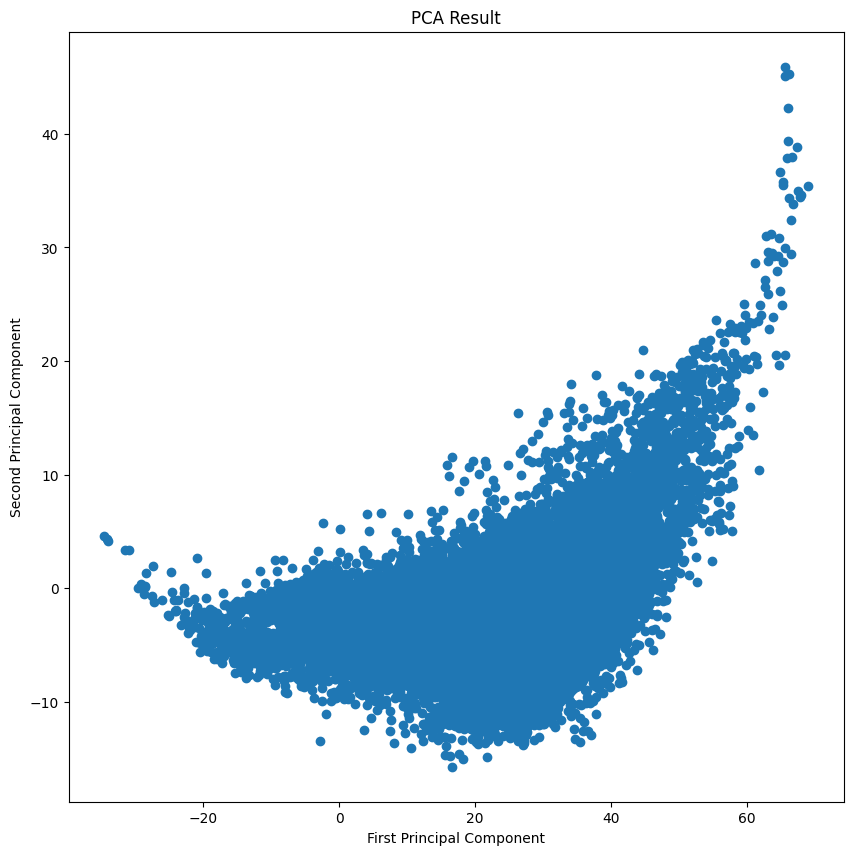

In [23]:
plt_pca2(pca_score_lists2)

In [24]:
culster_assignments,n=pca_kmeans(pca_score_lists2,main_images,10)

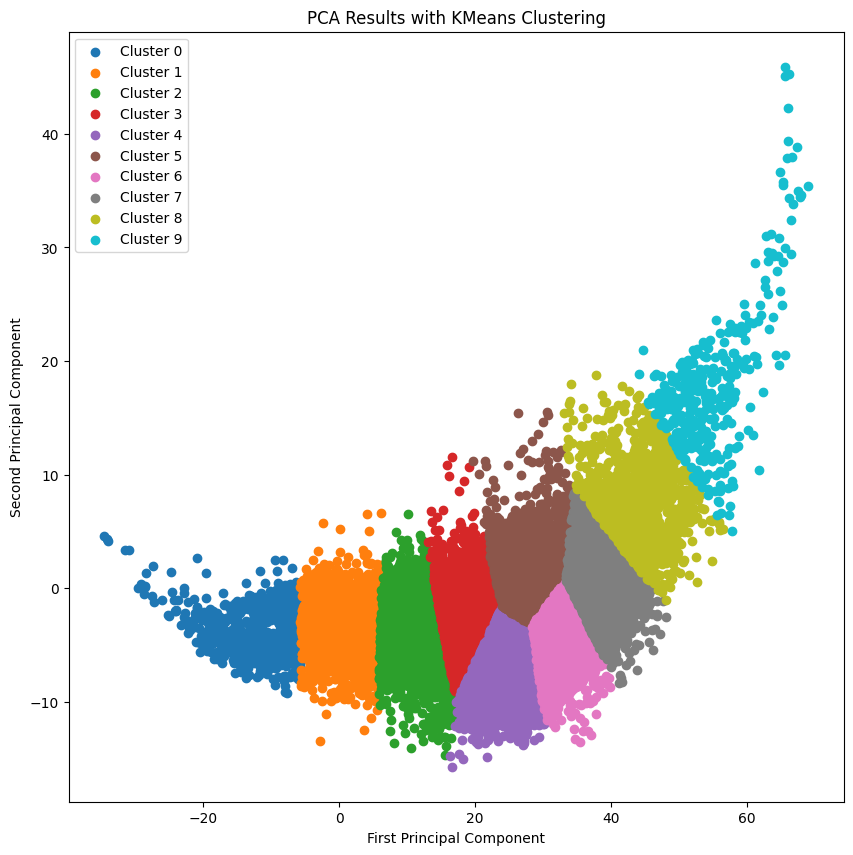

In [25]:
plt_pca2_kmeans(pca_score_lists2,culster_assignments,n)

In [26]:
# 元のフォルダパス
#実行は一回でいい
source_base_path = "imgs/kmeans2次元2/10"

# 新しいフォルダパス
update_img_path = "imgs/update_img2"

# フォルダのマッピング
folder_mapping = {
    "white": [0, 1],
    "light": [4, 5],
    "dark": [8, 9]
}

# フォルダを作成し、ファイルを移動
for new_folder, subfolders in folder_mapping.items():
    new_folder_path = os.path.join(update_img_path, new_folder)
    os.makedirs(new_folder_path, exist_ok=True)
    
    for subfolder in subfolders:
        subfolder_path = os.path.join(source_base_path, str(subfolder))
        
        if os.path.exists(subfolder_path):
            for filename in os.listdir(subfolder_path):
                source_file = os.path.join(subfolder_path, filename)
                destination_file = os.path.join(new_folder_path, filename)
                
                if os.path.isfile(source_file):
                    shutil.move(source_file, destination_file)

print("ファイルの移動が完了しました。")

ファイルの移動が完了しました。
